In [10]:
#!pip install matplotlib
#!pip install scikit-learn

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from datetime import datetime
from glob import glob
from collections import Counter

In [31]:
# Useful image utility
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)
from keras.preprocessing import image
from tensorflow.keras import utils

2.10.0


In [32]:
# data is from: http://vision.ucsd.edu/content/yale-face-database
# !wget -nc http://vision.ucsd.edu/datasets/yale_face_dataset_original/yalefaces.zip
!wget -nc https://lazyprogrammer.me/course_files/yalefaces.zip

File ‘yalefaces.zip’ already there; not retrieving.



In [14]:
!unzip yalefaces.zip

Archive:  yalefaces.zip
   creating: yalefaces/
  inflating: yalefaces/subject04.leftlight  
   creating: __MACOSX/
   creating: __MACOSX/yalefaces/
  inflating: __MACOSX/yalefaces/._subject04.leftlight  
  inflating: yalefaces/subject01.wink  
  inflating: __MACOSX/yalefaces/._subject01.wink  
  inflating: yalefaces/subject06.surprised  
  inflating: __MACOSX/yalefaces/._subject06.surprised  
  inflating: yalefaces/subject07.glasses  
  inflating: __MACOSX/yalefaces/._subject07.glasses  
  inflating: yalefaces/subject15.rightlight  
  inflating: __MACOSX/yalefaces/._subject15.rightlight  
  inflating: yalefaces/subject12.surprised  
  inflating: __MACOSX/yalefaces/._subject12.surprised  
  inflating: yalefaces/subject10.leftlight  
  inflating: __MACOSX/yalefaces/._subject10.leftlight  
  inflating: yalefaces/subject06.happy  
  inflating: __MACOSX/yalefaces/._subject06.happy  
  inflating: yalefaces/subject03.centerlight  
  inflating: __MACOSX/yalefaces/._subject03.centerlight  
  i

  inflating: yalefaces/subject10.surprised  
  inflating: __MACOSX/yalefaces/._subject10.surprised  
  inflating: yalefaces/subject09.wink  
  inflating: __MACOSX/yalefaces/._subject09.wink  
  inflating: yalefaces/subject02.noglasses  
  inflating: __MACOSX/yalefaces/._subject02.noglasses  
  inflating: yalefaces/subject11.rightlight  
  inflating: __MACOSX/yalefaces/._subject11.rightlight  
  inflating: yalefaces/subject13.wink  
  inflating: __MACOSX/yalefaces/._subject13.wink  
  inflating: yalefaces/subject09.surprised  
  inflating: __MACOSX/yalefaces/._subject09.surprised  
  inflating: yalefaces/subject12.centerlight  
  inflating: __MACOSX/yalefaces/._subject12.centerlight  
  inflating: yalefaces/subject05.wink  
  inflating: __MACOSX/yalefaces/._subject05.wink  
  inflating: yalefaces/subject10.glasses  
  inflating: __MACOSX/yalefaces/._subject10.glasses  
  inflating: yalefaces/subject04.wink  
  inflating: __MACOSX/yalefaces/._subject04.wink  
  inflating: yalefaces/subje

In [15]:
files = glob('yalefaces/subject*')

In [16]:
# easier to randomize later
np.random.shuffle(files)

In [17]:
# number of samples
N = len(files)
N

166

In [37]:
H, W = 60, 80
def load_img(filepath):
  # load image and downsample
  img = utils.img_to_array(utils.load_img(filepath, target_size=[H, W])).astype('uint8')
  return img

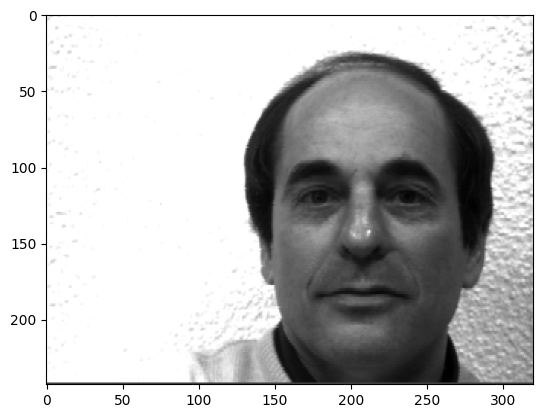

In [44]:
# look at an image for fun
img = utils.load_img(np.random.choice(files))
plt.imshow(img)
plt.show()

In [46]:
np.array(img).shape

(243, 320, 3)

In [48]:
np.array(img).max()

255

In [53]:
def to_grayscale(img):
  return np.array(img).mean(axis=-1)

In [55]:
img = np.array(img)
np.all(img[:,:,0] == img[:,:,1]), np.all(img[:,:,0] == img[:,:,2])

(True, True)

In [56]:
# load images as arrays
shape = (N, H, W)
images = np.zeros(shape)
for i, f in enumerate(files):
  img = to_grayscale(load_img(f)) / 255.
  images[i] = img

In [57]:
# make the labels
# all the filenames are something like 'subject13.happy'
labels = np.zeros(N)
for i, f in enumerate(files):
  filename = f.rsplit('/', 1)[-1]
  subject_num = filename.split('.', 1)[0]

  # subtract 1 since the filenames start from 1
  idx = int(subject_num.replace('subject', '')) - 1
  labels[i] = idx

In [58]:
# how many of each subject do we have?
label_count = Counter(labels)
label_count

Counter({3.0: 11,
         12.0: 11,
         13.0: 11,
         14.0: 11,
         7.0: 11,
         2.0: 11,
         1.0: 11,
         6.0: 11,
         10.0: 11,
         0.0: 12,
         8.0: 11,
         5.0: 11,
         4.0: 11,
         9.0: 11,
         11.0: 11})

In [59]:
# set of unique labels
unique_labels = set(label_count.keys())

In [60]:
# get the number of subjects
n_subjects = len(label_count)

In [61]:
# let's make it so 3 images for each subject are test data
# number of test points is then
n_test = 3 * n_subjects
n_train = N - n_test

In [62]:
# initialize arrays to hold train and test images
train_images = np.zeros((n_train, H, W))
train_labels = np.zeros(n_train)
test_images = np.zeros((n_test, H, W))
test_labels = np.zeros(n_test)

In [63]:
count_so_far = {}
train_idx = 0
test_idx = 0
images, labels = shuffle(images, labels)
for img, label in zip(images, labels):
  # increment the count
  count_so_far[label] = count_so_far.get(label, 0) + 1

  if count_so_far[label] > 3:
    # we have already added 3 test images for this subject
    # so add the rest to train
    train_images[train_idx] = img
    train_labels[train_idx] = label
    train_idx += 1

  else:
    # add the first 3 images to test
    test_images[test_idx] = img
    test_labels[test_idx] = label
    test_idx += 1

In [64]:
# create label2idx mapping for easy access
train_label2idx = {}
test_label2idx = {}

for i, label in enumerate(train_labels):
  if label not in train_label2idx:
    train_label2idx[label] = [i]
  else:
    train_label2idx[label].append(i)

for i, label in enumerate(test_labels):
  if label not in test_label2idx:
    test_label2idx[label] = [i]
  else:
    test_label2idx[label].append(i)

In [65]:
# come up with all possible training sample indices
train_positives = []
train_negatives = []
test_positives = []
test_negatives = []

for label, indices in train_label2idx.items():
  # all indices that do NOT belong to this subject
  other_indices = set(range(n_train)) - set(indices)

  for i, idx1 in enumerate(indices):
    for idx2 in indices[i+1:]:
      train_positives.append((idx1, idx2))

    for idx2 in other_indices:
      train_negatives.append((idx1, idx2))

for label, indices in test_label2idx.items():
  # all indices that do NOT belong to this subject
  other_indices = set(range(n_test)) - set(indices)

  for i, idx1 in enumerate(indices):
    for idx2 in indices[i+1:]:
      test_positives.append((idx1, idx2))

    for idx2 in other_indices:
      test_negatives.append((idx1, idx2))

In [66]:
batch_size = 64
def train_generator():
  # for each batch, we will send 1 pair of each subject
  # and the same number of non-matching pairs
  n_batches = int(np.ceil(len(train_positives) / batch_size))
  
  while True:
    np.random.shuffle(train_positives)
    n_samples = batch_size * 2
    shape = (n_samples, H, W)
    x_batch_1 = np.zeros(shape)
    x_batch_2 = np.zeros(shape)
    y_batch = np.zeros(n_samples)

    for i in range(n_batches):
      pos_batch_indices = train_positives[i * batch_size: (i + 1) * batch_size]

      # fill up x_batch and y_batch
      j = 0
      for idx1, idx2 in pos_batch_indices:
        x_batch_1[j] = train_images[idx1]
        x_batch_2[j] = train_images[idx2]
        y_batch[j] = 1 # match
        j += 1

      # get negative samples
      neg_indices = np.random.choice(len(train_negatives), size=len(pos_batch_indices), replace=False)
      for neg in neg_indices:
        idx1, idx2 = train_negatives[neg]
        x_batch_1[j] = train_images[idx1]
        x_batch_2[j] = train_images[idx2]
        y_batch[j] = 0 # non-match
        j += 1

      x1 = x_batch_1[:j]
      x2 = x_batch_2[:j]
      y = y_batch[:j]

      # reshape
      x1 = x1.reshape(-1, 1, H, W)
      x2 = x2.reshape(-1, 1, H, W)

      # convert to torch tensor
      x1 = torch.from_numpy(x1).float()
      x2 = torch.from_numpy(x2).float()
      y = torch.from_numpy(y).float()

      yield [x1, x2], y

In [67]:
# same thing as the train generator except no shuffling and it uses the test set
def test_generator():
  n_batches = int(np.ceil(len(test_positives) / batch_size))

  while True:
    n_samples = batch_size * 2
    shape = (n_samples, H, W)
    x_batch_1 = np.zeros(shape)
    x_batch_2 = np.zeros(shape)
    y_batch = np.zeros(n_samples)

    for i in range(n_batches):
      pos_batch_indices = test_positives[i * batch_size: (i + 1) * batch_size]

      # fill up x_batch and y_batch
      j = 0
      for idx1, idx2 in pos_batch_indices:
        x_batch_1[j] = test_images[idx1]
        x_batch_2[j] = test_images[idx2]
        y_batch[j] = 1 # match
        j += 1

      # get negative samples
      neg_indices = np.random.choice(len(test_negatives), size=len(pos_batch_indices), replace=False)
      for neg in neg_indices:
        idx1, idx2 = test_negatives[neg]
        x_batch_1[j] = test_images[idx1]
        x_batch_2[j] = test_images[idx2]
        y_batch[j] = 0 # non-match
        j += 1

      x1 = x_batch_1[:j]
      x2 = x_batch_2[:j]
      y = y_batch[:j]

      # reshape
      x1 = x1.reshape(-1, 1, H, W)
      x2 = x2.reshape(-1, 1, H, W)

      # convert to torch tensor
      x1 = torch.from_numpy(x1).float()
      x2 = torch.from_numpy(x2).float()
      y = torch.from_numpy(y).float()

      yield [x1, x2], y

In [68]:
# build the model
class SiameseNN(nn.Module):
  def __init__(self, feature_dim):
    super(SiameseNN, self).__init__()

    # define CNN featurizer
    self.cnn = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(13*18*64, 128), # 60>29>13,80>39>18
        nn.ReLU(),
        nn.Linear(128, feature_dim),
    )

  def forward(self, im1, im2):
    feat1 = self.cnn(im1)
    feat2 = self.cnn(im2)

    # Euclidean distance between feature 1 and feature 2
    return torch.norm(feat1 - feat2, dim=-1)

In [69]:
model = SiameseNN(50)

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


SiameseNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=14976, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=50, bias=True)
  )
)

In [71]:
# loss function for siamese network
def contrastive_loss(y, t):
  nonmatch = F.relu(1 - y) # max(margin - y, 0)
  return torch.mean(t * y**2 + (1 - t) * nonmatch**2)

In [72]:
# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters())

In [73]:
# A function to encapsulate the training loop
def batch_gd(
    model,
    criterion,
    optimizer,
    train_gen,
    test_gen,
    train_steps_per_epoch,
    test_steps_per_epoch,
    epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    steps = 0
    for (x1, x2), targets in train_gen:
      # move data to GPU
      x1, x2, targets = x1.to(device), x2.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(x1, x2)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

      # Update steps
      steps += 1
      if steps >= train_steps_per_epoch:
        break

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    model.eval()
    test_loss = []
    steps = 0
    for (x1, x2), targets in test_gen:
      x1, x2, targets = x1.to(device), x2.to(device), targets.to(device)
      outputs = model(x1, x2)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
      steps += 1
      if steps >= train_steps_per_epoch:
        break
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [74]:
train_steps = int(np.ceil(len(train_positives) / batch_size))
test_steps = int(np.ceil(len(test_positives) / batch_size))

train_losses, test_losses = batch_gd(
    model,
    contrastive_loss,
    optimizer,
    train_generator(),
    test_generator(),
    train_steps,
    test_steps,
    epochs=20)

Epoch 1/20, Train Loss: 0.7639,       Test Loss: 0.2953, Duration: 0:00:05.746741
Epoch 2/20, Train Loss: 0.2709,       Test Loss: 0.1748, Duration: 0:00:05.412034
Epoch 3/20, Train Loss: 0.1256,       Test Loss: 0.1133, Duration: 0:00:04.663333
Epoch 4/20, Train Loss: 0.0757,       Test Loss: 0.1051, Duration: 0:00:04.594392
Epoch 5/20, Train Loss: 0.0493,       Test Loss: 0.1079, Duration: 0:00:04.653599
Epoch 6/20, Train Loss: 0.0289,       Test Loss: 0.0915, Duration: 0:00:04.722000
Epoch 7/20, Train Loss: 0.0190,       Test Loss: 0.0878, Duration: 0:00:04.743794
Epoch 8/20, Train Loss: 0.0128,       Test Loss: 0.0917, Duration: 0:00:04.621782
Epoch 9/20, Train Loss: 0.0099,       Test Loss: 0.0865, Duration: 0:00:04.616755
Epoch 10/20, Train Loss: 0.0081,       Test Loss: 0.0851, Duration: 0:00:04.663976
Epoch 11/20, Train Loss: 0.0084,       Test Loss: 0.0821, Duration: 0:00:04.788938
Epoch 12/20, Train Loss: 0.0098,       Test Loss: 0.0905, Duration: 0:00:05.391114
Epoch 13/20, 

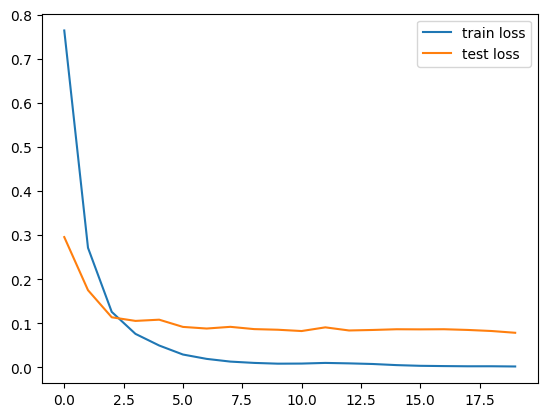

In [75]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [76]:
model.eval()

SiameseNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=14976, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=50, bias=True)
  )
)

In [77]:
# Convenience function to make predictions
def predict(x1, x2):
  x1 = torch.from_numpy(x1).float().to(device)
  x2 = torch.from_numpy(x2).float().to(device)
  with torch.no_grad():
    dist = model(x1, x2).cpu().numpy()
    return dist.flatten()

In [78]:
# calculate accuracy before training
# since the dataset is imbalanced, we'll report tp, tn, fp, fn
def get_train_accuracy(threshold=0.85):
  positive_distances = []
  negative_distances = []

  tp = 0
  tn = 0
  fp = 0
  fn = 0

  batch_size = 64
  x_batch_1 = np.zeros((batch_size, 1, H, W))
  x_batch_2 = np.zeros((batch_size, 1, H, W))
  n_batches = int(np.ceil(len(train_positives) / batch_size))
  for i in range(n_batches):
    print(f"pos batch: {i+1}/{n_batches}")
    pos_batch_indices = train_positives[i * batch_size: (i + 1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in pos_batch_indices:
      x_batch_1[j,0] = train_images[idx1]
      x_batch_2[j,0] = train_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    positive_distances += distances.tolist()

    # update tp, tn, fp, fn
    tp += (distances < threshold).sum()
    fn += (distances > threshold).sum()

  n_batches = int(np.ceil(len(train_negatives) / batch_size))
  for i in range(n_batches):
    print(f"neg batch: {i+1}/{n_batches}")
    neg_batch_indices = train_negatives[i * batch_size: (i + 1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in neg_batch_indices:
      x_batch_1[j,0] = train_images[idx1]
      x_batch_2[j,0] = train_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    negative_distances += distances.tolist()

    # update tp, tn, fp, fn
    fp += (distances < threshold).sum()
    tn += (distances > threshold).sum()

  tpr = tp / (tp + fn)
  tnr = tn / (tn + fp)
  print(f"sensitivity (tpr): {tpr}, specificity (tnr): {tnr}")

  plt.hist(negative_distances, bins=20, density=True, label='negative_distances')
  plt.hist(positive_distances, bins=20, density=True, label='positive_distances')
  plt.legend()
  plt.show()

In [79]:
def get_test_accuracy(threshold=0.85):
  positive_distances = []
  negative_distances = []

  tp = 0
  tn = 0
  fp = 0
  fn = 0

  batch_size = 64
  x_batch_1 = np.zeros((batch_size, 1, H, W))
  x_batch_2 = np.zeros((batch_size, 1, H, W))
  n_batches = int(np.ceil(len(test_positives) / batch_size))
  for i in range(n_batches):
    print(f"pos batch: {i+1}/{n_batches}")
    pos_batch_indices = test_positives[i * batch_size: (i + 1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in pos_batch_indices:
      x_batch_1[j,0] = test_images[idx1]
      x_batch_2[j,0] = test_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    positive_distances += distances.tolist()

    # update tp, tn, fp, fn
    tp += (distances < threshold).sum()
    fn += (distances > threshold).sum()

  n_batches = int(np.ceil(len(test_negatives) / batch_size))
  for i in range(n_batches):
    print(f"neg batch: {i+1}/{n_batches}")
    neg_batch_indices = test_negatives[i * batch_size: (i + 1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in neg_batch_indices:
      x_batch_1[j] = test_images[idx1]
      x_batch_2[j] = test_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    negative_distances += distances.tolist()

    # update tp, tn, fp, fn
    fp += (distances < threshold).sum()
    tn += (distances > threshold).sum()


  tpr = tp / (tp + fn)
  tnr = tn / (tn + fp)
  print(f"sensitivity (tpr): {tpr}, specificity (tnr): {tnr}")

  plt.hist(negative_distances, bins=20, density=True, label='negative_distances')
  plt.hist(positive_distances, bins=20, density=True, label='positive_distances')
  plt.legend()
  plt.show()

pos batch: 1/7
pos batch: 2/7
pos batch: 3/7
pos batch: 4/7
pos batch: 5/7
pos batch: 6/7
pos batch: 7/7
neg batch: 1/214
neg batch: 2/214
neg batch: 3/214
neg batch: 4/214
neg batch: 5/214
neg batch: 6/214
neg batch: 7/214
neg batch: 8/214
neg batch: 9/214
neg batch: 10/214
neg batch: 11/214
neg batch: 12/214
neg batch: 13/214
neg batch: 14/214
neg batch: 15/214
neg batch: 16/214
neg batch: 17/214
neg batch: 18/214
neg batch: 19/214
neg batch: 20/214
neg batch: 21/214
neg batch: 22/214
neg batch: 23/214
neg batch: 24/214
neg batch: 25/214
neg batch: 26/214
neg batch: 27/214
neg batch: 28/214
neg batch: 29/214
neg batch: 30/214
neg batch: 31/214
neg batch: 32/214
neg batch: 33/214
neg batch: 34/214
neg batch: 35/214
neg batch: 36/214
neg batch: 37/214
neg batch: 38/214
neg batch: 39/214
neg batch: 40/214
neg batch: 41/214
neg batch: 42/214
neg batch: 43/214
neg batch: 44/214
neg batch: 45/214
neg batch: 46/214
neg batch: 47/214
neg batch: 48/214
neg batch: 49/214
neg batch: 50/214
neg 

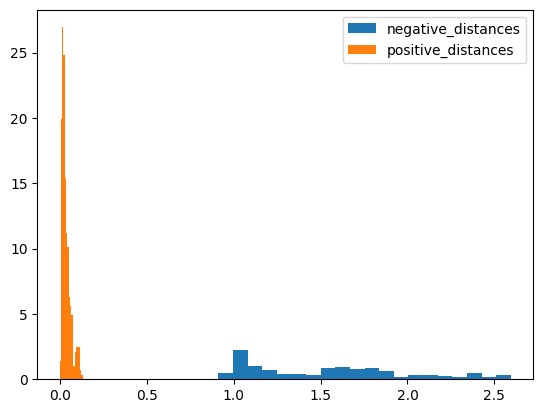

In [80]:
get_train_accuracy(0.65)

pos batch: 1/1
neg batch: 1/30
neg batch: 2/30
neg batch: 3/30
neg batch: 4/30
neg batch: 5/30
neg batch: 6/30
neg batch: 7/30
neg batch: 8/30
neg batch: 9/30
neg batch: 10/30
neg batch: 11/30
neg batch: 12/30
neg batch: 13/30
neg batch: 14/30
neg batch: 15/30
neg batch: 16/30
neg batch: 17/30
neg batch: 18/30
neg batch: 19/30
neg batch: 20/30
neg batch: 21/30
neg batch: 22/30
neg batch: 23/30
neg batch: 24/30
neg batch: 25/30
neg batch: 26/30
neg batch: 27/30
neg batch: 28/30
neg batch: 29/30
neg batch: 30/30
sensitivity (tpr): 0.9555555555555556, specificity (tnr): 0.9608465608465608


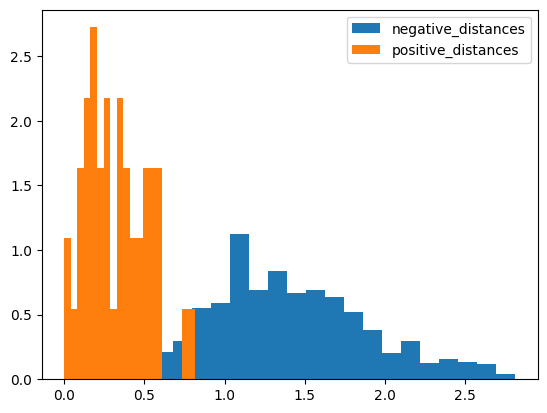

In [81]:
get_test_accuracy(0.65)